In [88]:
import numpy as np
import pandas as pd
##### imports for LSTM
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
from sklearn.metrics import confusion_matrix


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [89]:
# cols = ['Compound Sentiment Score','sentiment change','High','Low','Open','Close','Volume','Marketcap','Volatility','date']

# org_df = pd.read_csv('arima_sentiment.csv', usecols=cols)
# org_df.to_csv('sent_price_numerical.csv', header=True, index=False, columns=list(org_df.axes[1]))

In [102]:
org_df = pd.read_csv('sent_price_numerical.csv', parse_dates=['date'])
org_df.set_index('date', inplace=True)

org_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2849 entries, 2013-04-29 to 2021-02-14
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Compound Sentiment Score  2849 non-null   float64
 1   sentiment change          2849 non-null   float64
 2   High                      2849 non-null   float64
 3   Low                       2849 non-null   float64
 4   Open                      2849 non-null   float64
 5   Close                     2849 non-null   float64
 6   Volume                    2849 non-null   float64
 7   Marketcap                 2849 non-null   float64
 8   Volatility                2849 non-null   float64
dtypes: float64(9)
memory usage: 222.6 KB


# creating monthly returns

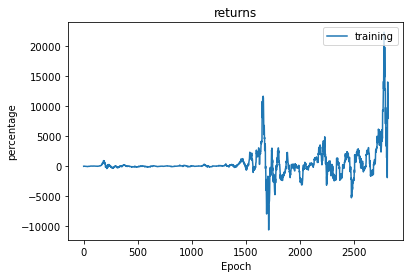

<ipython-input-91-87727885f74e>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['monthly returns'] = monthly_returns


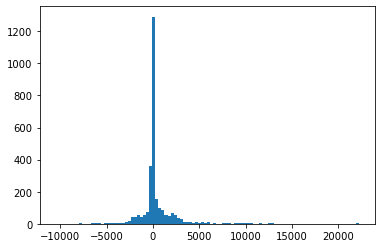

In [91]:
close = org_df['Close']

monthly_returns = []

for i in range(0, len(close)-30):
#     print(i)
#     print(close[i])
    result = (close[i+30]-close[i])
    monthly_returns.append(result)
#     print(i)

# detrend = []

# for i in range(0, len(close)-1):
#     result = ((close[i+1]-close[i])/close[i])*100
#     detrend.append(result)
    
# detrend
# # plt.plot(history.history['loss'])
# plt.plot(monthly_returns)
plt.plot(monthly_returns)
plt.title('returns')
plt.ylabel('percentage')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# min(monthly_returns), max(monthly_returns)

plt.hist(monthly_returns, bins=100)

# df
    
# returns = org_df['Close']
# returns

df = org_df[30:]
df['monthly returns'] = monthly_returns

In [92]:
org_df = df.copy(deep=True)
org_df

,Compound Sentiment Score,sentiment change,High,Low,Open,Close,Volume,Marketcap,Volatility,monthly returns
date,,,,,,,,,,
2013-05-29,0.37030,-0.04600,132.589996,127.662003,129.000000,132.300003,0.000000e+00,1.483735e+09,3.860188,-12.239990
2013-05-30,0.40190,0.03160,132.250000,127.000000,132.250000,128.798996,0.000000e+00,1.445054e+09,4.133858,-10.201004
2013-05-31,-0.10985,-0.51175,129.899994,126.400002,128.798996,129.000000,0.000000e+00,1.447870e+09,2.768981,12.010002
2013-06-01,0.49270,0.60255,129.779999,127.198997,128.815002,129.300003,0.000000e+00,1.451916e+09,2.029105,24.090004
2013-06-02,0.62490,0.13220,129.399994,115.050003,129.300003,122.292000,0.000000e+00,1.373837e+09,12.472830,24.542000
...,...,...,...,...,...,...,...,...,...,...
2021-02-10,0.40190,0.00000,47145.568199,43881.152599,46469.761202,44918.184492,8.730109e+10,8.366169e+11,7.439220,9351.528551
2021-02-11,0.41990,0.01800,48463.467125,44187.762351,44898.711611,47909.331195,8.138891e+10,8.923649e+11,9.676219,13986.370613
2021-02-12,0.40190,-0.01800,48745.733800,46424.977818,47877.034375,47504.851183,7.655504e+10,8.848741e+11,4.998938,10188.491783


# Data scaling

In [93]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# print('dataset.shape', dataset.shape)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)


Number of features 10


config

In [94]:
expr_name = 'expr_1'
look_back = 60 # 60 days
lstm_layers = 32
epochs=10
batch_size=128

spliting datasets into train and test¶


In [95]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('Close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  2255
Testing dataset length  564
look_back  60


Build the model and train¶


In [96]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/10
12/12 [==============================] - 6s 220ms/step - loss: 0.0012 - val_loss: 0.0110
Epoch 2/10
12/12 [==============================] - 0s 32ms/step - loss: 0.0011 - val_loss: 0.0168
Epoch 3/10
12/12 [==============================] - 0s 32ms/step - loss: 3.4685e-04 - val_loss: 0.0112
Epoch 4/10
12/12 [==============================] - 0s 33ms/step - loss: 4.3243e-05 - val_loss: 0.0057
Epoch 5/10
12/12 [==============================] - 1s 57ms/step - loss: 1.3236e-04 - val_loss: 0.0046
Epoch 6/10
12/12 [==============================] - 0s 36ms/step - loss: 6.5377e-05 - val_loss: 0.0025
Epoch 7/10
12/12 [==============================] - 0s 32ms/step - loss: 3.5111e-05 - val_loss: 0.0012
Epoch 8/10
12/12 [==============================] - 0s 37ms/step - loss: 3.9452e-05 - val_loss: 6.7089e-04
Epoch 9/10
12/12 [==============================] - 0s 34ms/step - loss: 3.5178e-05 - val_loss: 4.0822e-04
Epoch 10/10
12/12 [==============================] - 0s 36ms/step - loss

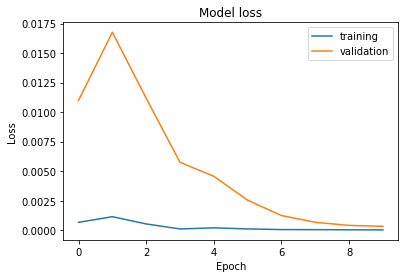

In [97]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [98]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

Text(0.5, 1.0, 'Bitcoin Price Prediction')

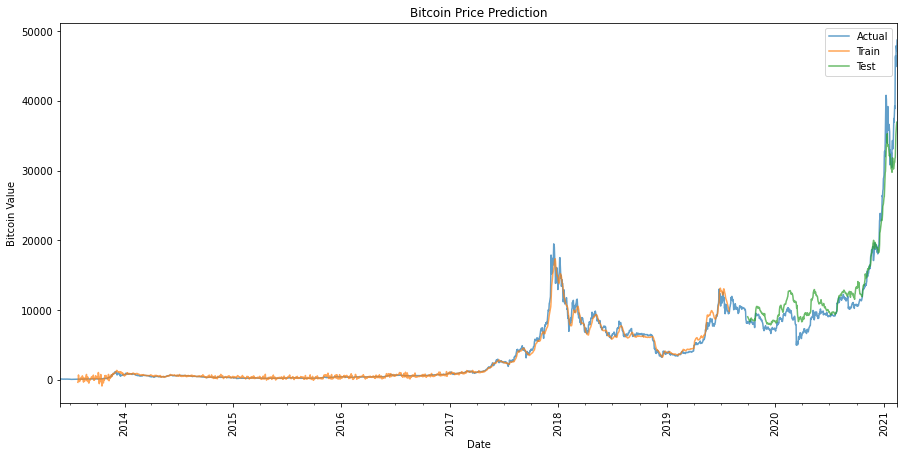

In [99]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
# plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [100]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_1
--------------------------------------------------
look_back days: 60
lstm_layers: 32
epochs: 10
batch_size: 128
dataset features ['Compound Sentiment Score', 'sentiment change', 'High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap', 'Volatility', 'monthly returns']
--------------------------------------------------
Train Score: 509.95 RMSE
Test Score: 2448.76 RMSE
--------------------------------------------------
Train Score: 280.42 MAE
Test Score: 1729.55 MAE
--------------------------------------------------
Model summary:
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,

In [ ]:
# confusion_matrix()

In [101]:
# train_predict = model.predict(trainX)
# test_predict = model.predict(testX)
# invert predictions
# trainPredict_extended
# train_predict = scaler.inverse_transform(trainPredict_extended)
# Y_train = scaler.inverse_transform([trainY])
# test_predict = scaler.inverse_transform(test_predict)
# Y_test = scaler.inverse_transform([Ytest])
# print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
# print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(trainY[0], train_predict[:,0])))
# print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
# print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [33]:
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))
trainScore_RMSE,testScore_RMSE

(29.63926543091603, 33.58710807575396)